In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import ensemble

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

## 1. Знакомство с данными

In [20]:
X_train = np.load('motorica-skillfactory-internship-test-task-2023-12/X_train.npy')
print(X_train.shape)
y_train = pd.read_csv('motorica-skillfactory-internship-test-task-2023-12/y_train.csv')
print(y_train.shape)
X_test = np.load('motorica-skillfactory-internship-test-task-2023-12/X_test.npy')
print(X_test.shape)
y_sub = pd.read_csv('motorica-skillfactory-internship-test-task-2023-12/sample_submission.csv')
print(y_sub.shape)

(323, 40, 100)
(32300, 2)
(54, 40, 100)
(5400, 2)


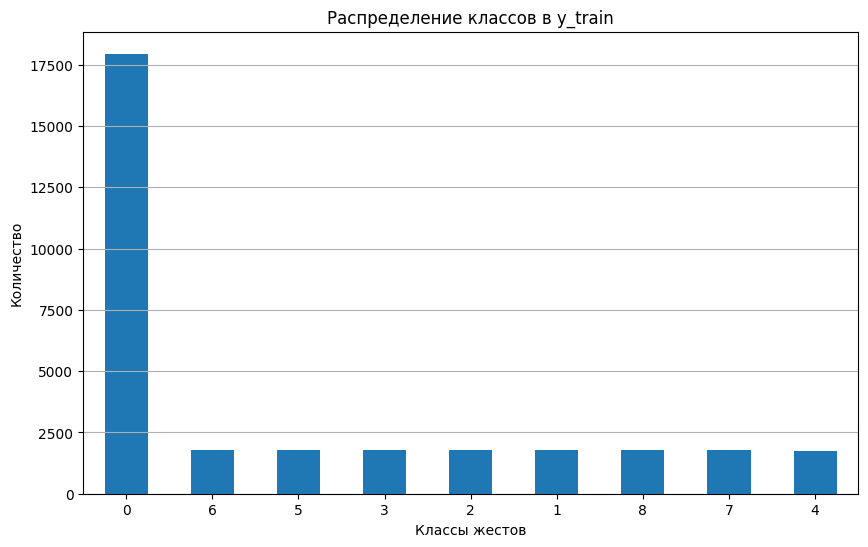

In [21]:
# Подсчет распределения классов в y_train
class_distribution = y_train['class'].value_counts()

# Визуализация распределения классов
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Распределение классов в y_train')
plt.xlabel('Классы жестов')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

- Класс 0 (команда "жест open") значительно преобладает над остальными классами. Его количество составляет 17950, что значительно больше, чем у других классов.
- Остальные классы (от 1 до 8) представлены примерно в равных количествах, от 1750 до 1800 наблюдений каждый.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


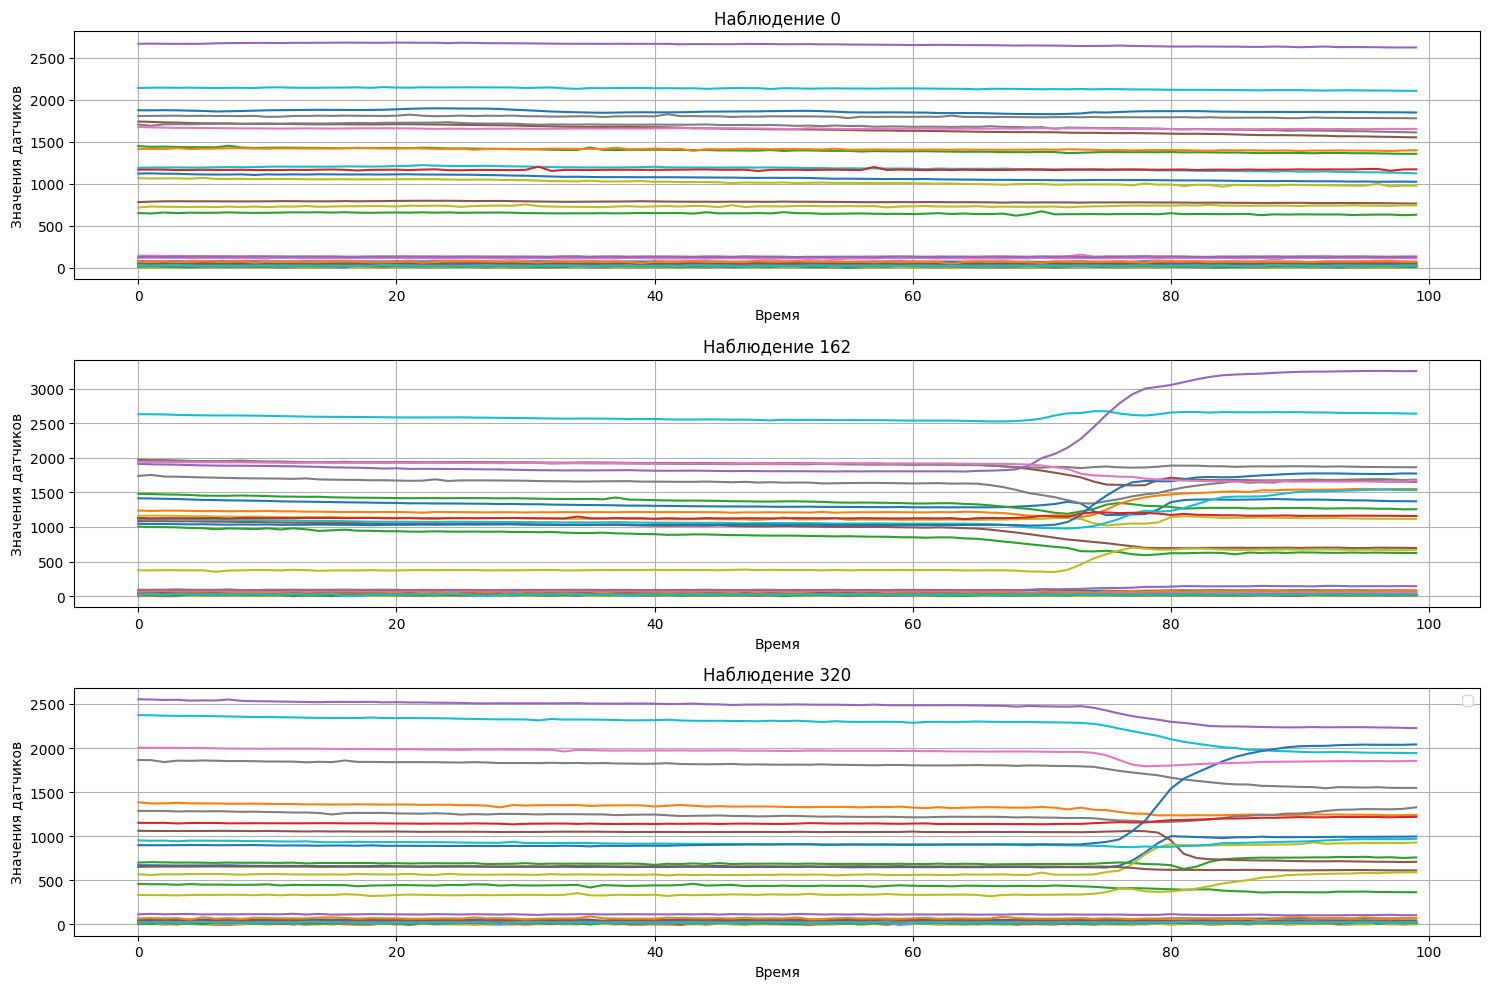

In [22]:
# Визуализация данных с датчиков для выборочных наблюдений
sample_indices = [0, 162, 320]  # Выбор нескольких случайных наблюдений для визуализации
num_sensors = X_train.shape[1]  # Количество датчиков

plt.figure(figsize=(15, 10))

for i, sample_index in enumerate(sample_indices, 1):
    plt.subplot(len(sample_indices), 1, i)
    for sensor in range(num_sensors):
        plt.plot(X_train[sample_index, sensor, :], label=f'Датчик {sensor}' if i == 1 else "")
    plt.title(f'Наблюдение {sample_index}')
    plt.xlabel('Время')
    plt.ylabel('Значения датчиков')
    plt.grid(True)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

На представленных графиках показаны данные с датчиков для трех выборочных наблюдений из нормализованной обучающей выборки. Каждый график отображает изменения показаний всех 40 датчиков во времени для одного наблюдения. Эти визуализации помогают нам увидеть, как различные датчики реагируют в разные моменты времени, что может быть связано с выполнением различных жестов.

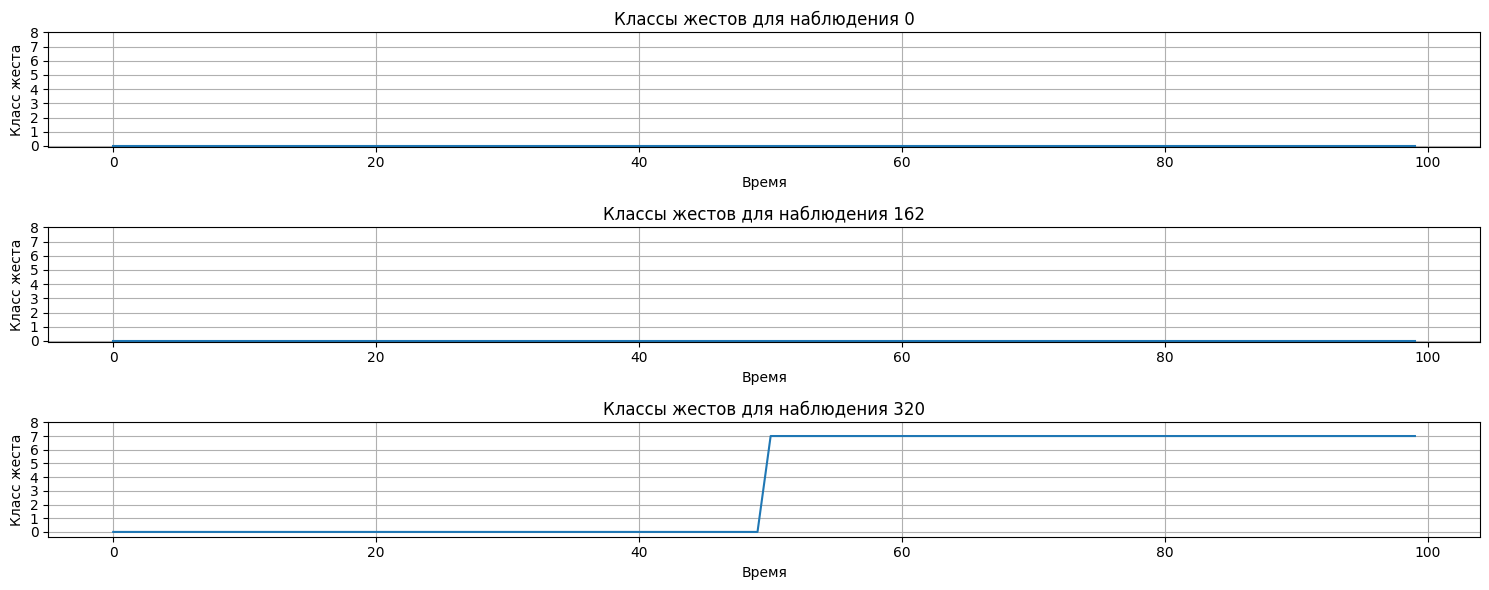

In [23]:
y_train_plot = y_train.copy()
y_train_plot[['sample', 'timestep']] = y_train_plot['sample-timestep'].str.split('-', expand=True).astype(int)
y_train_plot = y_train_plot.drop(columns=['sample-timestep'])
y_train_reshaped = y_train_plot.pivot(index='sample', columns='timestep', values='class').values

# Визуализация классов жестов для тех же наблюдений
plt.figure(figsize=(15, 6))

for i, sample_index in enumerate(sample_indices, 1):
    plt.subplot(len(sample_indices), 1, i)
    plt.plot(y_train_reshaped[sample_index, :], label=f'Наблюдение {sample_index}')
    plt.title(f'Классы жестов для наблюдения {sample_index}')
    plt.xlabel('Время')
    plt.ylabel('Класс жеста')
    plt.yticks(range(9))  # 9 классов жестов
    plt.grid(True)

plt.tight_layout()
plt.show()

Несколько наблюдений из анализа:

В некоторых случаях видны чёткие переходы между разными классами жестов, что может указывать на моменты, когда пользователь меняет жест.
Наблюдаются периоды стабильности, где класс жеста не меняется в течение некоторого времени.

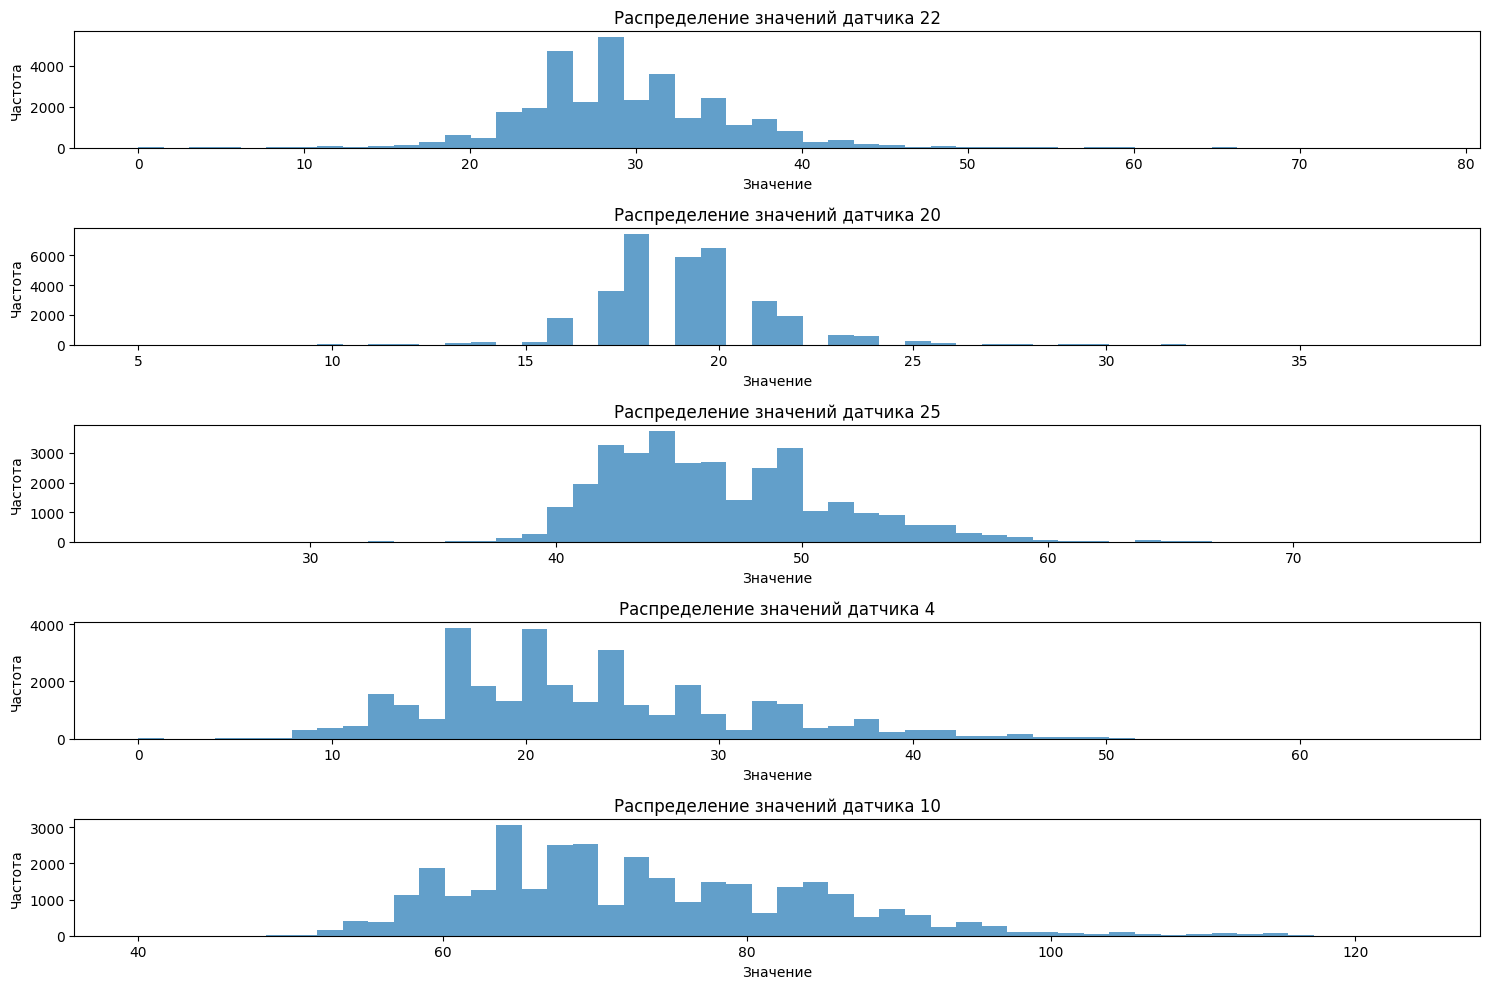

In [16]:
np.random.seed(0)  # Для воспроизводимости результатов
num_sensors = 5  # Количество датчиков для визуализации
random_sensors = np.random.choice(X_train.shape[1], num_sensors, replace=False)

plt.figure(figsize=(15, 10))
for i, sensor in enumerate(random_sensors, 1):
    plt.subplot(num_sensors, 1, i)
    plt.hist(X_train[:, sensor, :].flatten(), bins=50, alpha=0.7)
    plt.title(f'Распределение значений датчика {sensor}')
    plt.xlabel('Значение')
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

На гистограммах выше представлены распределения значений для случайно выбранных датчиков. Из визуального анализа видно, что распределения не выглядят как нормальные — они либо скошены, либо многомодальны.

In [18]:
# Функция для проведения теста Шапиро-Уилка на выборке данных датчика
def test_normality(data, sample_size=500, alpha=0.05):
    if len(data) > sample_size:  # Если данных слишком много, используем подвыборку
        data = np.random.choice(data, size=sample_size, replace=False)
    stat, p = shapiro(data)
    return 'Нормальное распределение' if p > alpha else 'Не нормальное распределение'

# Проведем тест для каждого датчика
normality_test_results = [test_normality(X_train[:, sensor, :].flatten()) for sensor in range(X_train.shape[1])]

# Выведем результаты для первых 10 датчиков для экономии места
normality_test_results[:10]

['Не нормальное распределение',
 'Не нормальное распределение',
 'Не нормальное распределение',
 'Не нормальное распределение',
 'Не нормальное распределение',
 'Не нормальное распределение',
 'Не нормальное распределение',
 'Не нормальное распределение',
 'Не нормальное распределение',
 'Не нормальное распределение']

Результаты теста Шапиро-Уилка показывают, что распределения значений по каждому из первых 10 датчиков не следуют нормальному распределению. Это согласуется с визуальным анализом гистограмм. Следовательно, применение масштабирования данных может быть полезным для моделирования, особенно если будут использоваться методы, чувствительные к масштабу данных, такие как нейронные сети.

## 2. Преобразование данных

Создадим функцию для преобразования трехмерных массивов данных в плоский формат DataFrame. Это необходимо для дальнейшего анализа и обработки данных, так как многие методы машинного обучения требуют двумерных данных.

In [3]:
def transform_to_df(np_3D):
    samples = []
        
    for X in np_3D:
        timesteps = np.arange(X.shape[1])
        X_transformed = np.column_stack((X.T, timesteps))
        samples.append(X_transformed)
    
    return np.row_stack(samples)

In [4]:
X_train_df = pd.DataFrame(transform_to_df(X_train), index=y_train['sample-timestep'])
X_test_df = pd.DataFrame(transform_to_df(X_test), index=y_sub['sample-timestep'])

display(X_train_df.head())
display(X_test_df.head())

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
sample-timestep,,,,,,,,,,,,,,,,,,,,,
0-0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0,0.0
0-1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0,1.0
0-2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0,2.0
0-3,1120.0,10.0,1440.0,59.0,32.0,1730.0,143.0,6.0,1066.0,13.0,...,68.0,13.0,1165.0,131.0,29.0,1667.0,24.0,726.0,34.0,3.0
0-4,1115.0,16.0,1437.0,51.0,30.0,1724.0,138.0,4.0,1062.0,12.0,...,73.0,9.0,1165.0,133.0,29.0,1667.0,32.0,724.0,24.0,4.0


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
sample-timestep,,,,,,,,,,,,,,,,,,,,,
323-0,1681.0,4.0,1834.0,33.0,26.0,2254.0,43.0,0.0,1376.0,27.0,...,82.0,16.0,1204.0,108.0,25.0,1685.0,27.0,386.0,25.0,0.0
323-1,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0,1.0
323-2,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0,2.0
323-3,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,66.0,14.0,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0,3.0
323-4,1670.0,3.0,1831.0,36.0,28.0,2249.0,40.0,8.0,1368.0,18.0,...,76.0,30.0,1207.0,107.0,26.0,1691.0,29.0,391.0,4.0,4.0


Так как из анализа на нормальность мы выяснили, что данные не рапспрделены нормально, то необходимо провести масшатибрование данных

In [5]:
scaler = StandardScaler()
scaler.fit(X_train_df)

X_train_scaled = scaler.transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

y_train_class = y_train['class']

## 3. Обучение модели

Создадим функции для оценки модели с кросс-валидацией и выбора лучших параметров модели:

In [6]:
def cv_metrics(model, kfold=KFold()):
    
    cv_metrics = cv(
        estimator=model, #модель
        X=X_train_scaled, #матрица наблюдений X
        y=y_train_class, #вектор ответов y
        scoring='f1_weighted', #метрика
        cv = kfold,
        return_train_score=True #подсчёт метрики на тренировочных фолдах
    )
    
    print('Train k-fold mean f1_weighted: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
    print('Valid k-fold mean f1_weighted: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
    
def best_model_param(model, param_grid):
    
    cv_metrics(model)
    
    grid_search = GridSearchCV(
        estimator= model, 
        param_grid=param_grid, 
        n_jobs = -1
    )
    
    grid_search.fit(X_train_scaled, y_train_class)
    
    print(f'\nBest model has such params: {grid_search.best_params_}\n')
    
    cv_metrics(grid_search.best_estimator_)
    
    return grid_search.best_estimator_

Моя тактика максимально простая - обучать модели, с которыми я ранее работала в процессе обучения, перебирать их параметры и потом сабмитить их в соревнование. Поэтому начнем с базовой модели LogisticRegression

### LogisticRegression

In [7]:
#Создаём модель
log_reg = LogisticRegression(
    random_state=42, max_iter=1000
)

log_reg_param = {'multi_class': ['ovr', 'multinomial'], 
                'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}

log_reg_best = best_model_param(log_reg, log_reg_param)

Train k-fold mean f1_weighted: 0.82
Valid k-fold mean f1_weighted: 0.77

Best model has such params: {'multi_class': 'ovr', 'solver': 'lbfgs'}

Train k-fold mean f1_weighted: 0.82
Valid k-fold mean f1_weighted: 0.79


### SGDCClassifier

In [89]:
sgd_clf = SGDClassifier(random_state=42)

sgd_clf_param = {'alpha': [0.01, 0.1, 1], 
              'learning_rate': ['constant', 'optimal', 'adaptive'], 
              'eta0': [1, 10, 50, 100]}

sgd_clf_best = best_model_param(sgd_clf, sgd_clf_param) 

Train k-fold mean f1_weighted: 0.83
Valid k-fold mean f1_weighted: 0.81

Best model has such params: {'alpha': 0.01, 'eta0': 10, 'learning_rate': 'adaptive'}

Train k-fold mean f1_weighted: 0.82
Valid k-fold mean f1_weighted: 0.81


### DecisionTreeClassifier

In [8]:
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    random_state=42
)

dt_clf_param = {'criterion': ['gini', 'entropy'], 
                'max_depth': range(1,7), 
                'min_samples_leaf': range(1,5)}

df_clf_best = best_model_param(dt_clf, dt_clf_param)

Train k-fold mean f1_weighted: 1.00
Valid k-fold mean f1_weighted: 0.78

Best model has such params: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4}

Train k-fold mean f1_weighted: 0.83
Valid k-fold mean f1_weighted: 0.77


### RandomForestClassifier

In [9]:
rf_clf = ensemble.RandomForestClassifier(
    random_state=42
)

rf_clf_param = {'n_estimators':[100, 300, 500],
    'max_depth': range(1,8),
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': range(1,5),
    'max_features': ['auto', 'sqrt', 'log2']}

rf_clf_best = best_model_param(rf_clf, rf_clf_param)

Train k-fold mean f1_weighted: 1.00
Valid k-fold mean f1_weighted: 0.85

Best model has such params: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100}

Train k-fold mean f1_weighted: 0.84
Valid k-fold mean f1_weighted: 0.78


### GradientBoostingClassifier

In [43]:
gb_clf = ensemble.GradientBoostingClassifier(
    random_state=42
)

gb_clf_param = {'learning_rate': [0.01, 0.1], #темп обучения
    'n_estimators': [100,250],
    'max_depth': range(2,4,6)}

gb_clf_best = best_model_param(gb_clf, gb_clf_param)

Train k-fold mean f1_weighted: 0.98
Valid k-fold mean f1_weighted: 0.84

Best model has such params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 250}

Train k-fold mean f1_weighted: 0.97
Valid k-fold mean f1_weighted: 0.81


### MLPClassifier

In [77]:
from sklearn.neural_network import MLPClassifier  # многослойный персептрон (просто много полносвязных слоев)

mlp_clf = MLPClassifier(max_iter=10, random_state=42)

mlp_clf_param = {
    'max_iter': [10,20,30],
    'activation': ['relu', 'identity', 'logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

mlp_clf_best = best_model_param(mlp_clf, mlp_clf_param)

Train k-fold mean f1_weighted: 0.84
Valid k-fold mean f1_weighted: 0.79


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_mult


Best model has such params: {'activation': 'tanh', 'learning_rate': 'constant', 'max_iter': 30, 'solver': 'adam'}

Train k-fold mean f1_weighted: 0.96
Valid k-fold mean f1_weighted: 0.86


## 4. Предсказание на тестовой выборке

В процессе выполнения тестового задания я выбрала три модели: LogisticREgression, MLP, GradientBoosting и SGDClassifier, и поочередно отправляла результаты. Самый лучший результат показала модель SGDClassifier, и я предполагаю, что это связано с тем, что метрики на валидационных и тренировочных наборах данных имеют наименьшее различие, что указывает на стабильность модели.

In [86]:
y_pred = sgd_clf_best.predict(X_test_scaled)
y_pred

array([4, 4, 4, ..., 4, 4, 4])

In [90]:
indexes = pd.Series(X_test_df.index)
y = pd.Series(y_pred)
sub = pd.concat([indexes, y], axis=1)
sub.columns = ['sample-timestep', 'class']
sub

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4


In [91]:
sub.to_csv('y_test_prediction_sgd.csv', index=False)

P.S. Вообще я очень много времени потратила на то, чтобы обучить нейроную сеть **LSTM**, потому что по описанию она хорошо подходит для решения данной задачи, но к сожалению, у меня не получилось, но буду рада, если кто-нибудь мне поможет с этим разобраться 🙂